In [1]:
from importlib import reload
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from binance.client import Client
from binance import enums

In [2]:
# Your API key and secret
API_KEY = "S8bjtGTUyM5SUYLFLJtKwAxA2rov5mei4YZgU4wY36upWFZDZ4H8Zr4vmU22v403"
API_SECRET = "zwDSpBnofjMth8BwX3O4Et1T4kcneZ3J5n212ThThIWLDmedS51j5WFGEiGx16AL"

In [3]:
client = Client(API_KEY, API_SECRET)

In [4]:
# List of pairs you want to track
pairs = [
    ('BTC', 'USDT'),
    ('ETH', 'USDT'),
    ('XRP', 'USDT'),
    ('LTC', 'USDT'),
    ('BNB', 'USDT')
]
# https://python-binance.readthedocs.io/en/latest/genindex.html
# Kline/candlestick interval
# Fetch double of that to display in order to calculate windows correctly
interval = enums.KLINE_INTERVAL_1DAY
limit = 60

In [286]:
import importlib
import cryptoz
importlib.reload(cryptoz)

import cryptoz.binance
importlib.reload(cryptoz.binance)
from cryptoz.binance import BinanceHelper

import cryptoz.utils
importlib.reload(cryptoz.utils)
from cryptoz import utils

import cryptoz.plots
importlib.reload(cryptoz.plots)
from cryptoz import plots

import cryptoz.stats
importlib.reload(cryptoz.stats)
from cryptoz import stats

In [6]:
binance = BinanceHelper(client)

## Data

In [9]:
data_dict = binance.get_multiple_pair_ohlcv(pairs, interval, limit=limit)

In [10]:
data_dict.keys()

dict_keys([('BTC', 'USDT'), ('ETH', 'USDT'), ('XRP', 'USDT'), ('LTC', 'USDT'), ('BNB', 'USDT')])

## Basic statistics

In [288]:
from datetime import datetime
df = pd.DataFrame({'a': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'b': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]}, index=[
    datetime(2018, 1, 1, 1, 1, 1),
    datetime(2018, 1, 1, 1, 1, 2),
    datetime(2018, 1, 1, 1, 1, 3),
    datetime(2018, 1, 1, 1, 2, 1),
    datetime(2018, 1, 1, 1, 2, 2),
    datetime(2018, 1, 1, 1, 2, 3),
    datetime(2018, 1, 1, 1, 3, 1),
    datetime(2018, 1, 1, 1, 3, 2),
    datetime(2018, 1, 1, 1, 3, 3),
    datetime(2018, 1, 1, 1, 4, 1),
    datetime(2018, 1, 1, 1, 4, 2)
])

In [289]:
df

,a,b
2018-01-01 01:01:01,0,10
2018-01-01 01:01:02,1,9
2018-01-01 01:01:03,2,8
2018-01-01 01:02:01,3,7
2018-01-01 01:02:02,4,6
2018-01-01 01:02:03,5,5
2018-01-01 01:03:01,6,4
2018-01-01 01:03:02,7,3
2018-01-01 01:03:03,8,2
2018-01-01 01:04:01,9,1


In [ ]:
utils.normalize()

### Price development

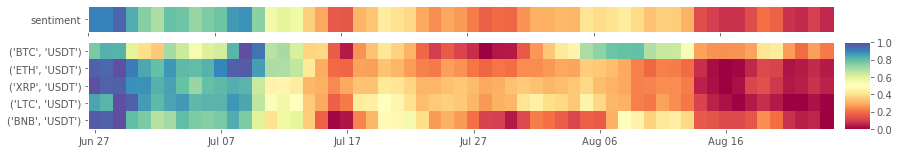

In [285]:
# Select a column from each OHLCV dataframe and stack into a new one
df = utils.build_from_dict(data_dict, 'M')

# We want to somehow compare prices of all assets
# Thus let's normalize the prices based on their performance
# To have a better overview, we normalize here with respect to both past and future
# In more sensitive settings, use expanding_normalize to use the past data only.
df = utils.normalize(df, 'minmax')

# Plot price evolution (i.e. price development heatmap)
# 1: the highest price (for a pair and window)
# 0: the lowest price
plots.evolution(df, norm=plots.midpoint_norm(0.5), vmin=0, vmax=1)

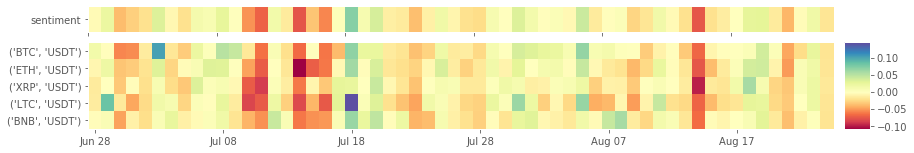

In [57]:
# Percentage change between the current and a prior price.
df = utils.build_from_dict(data_dict, 'M')
df = df.pct_change().dropna()

plots.evolution(df, norm=plots.midpoint_norm(0))

### Price volatility

In [58]:
# Normalized volatility of each pair
df = utils.build_from_dict(data_dict, 'M')
df = df.std() / df.mean()
df.sort_values()

BTC  USDT    0.073395
BNB  USDT    0.079760
XRP  USDT    0.140625
LTC  USDT    0.166351
ETH  USDT    0.172826
dtype: float64

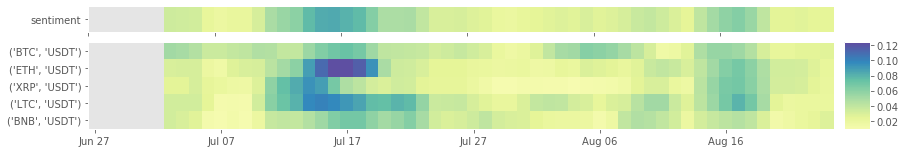

In [60]:
# Show development of the normalized volatility (smoothed)
df = utils.build_from_dict(data_dict, 'M')
df = df.rolling(7).std() / df.rolling(7).mean()

plots.evolution(df, norm=plots.midpoint_norm(0))

## Volume

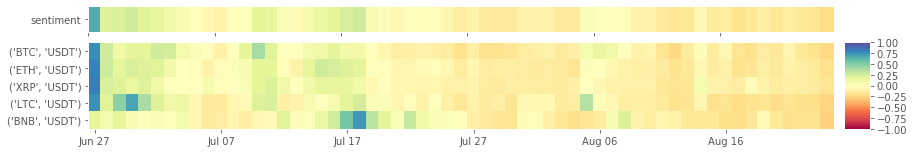

In [283]:
# Compare the development of volume for different pairs
df = utils.build_from_dict(data_dict, 'V')
# -1: the minimum volume (for a pair and window)
# 0: the mean volume
# 1: the maximum volume
df = utils.normalize(df, 'mean')

plots.evolution(df, norm=plots.midpoint_norm(0), vmin=-1, vmax=1)

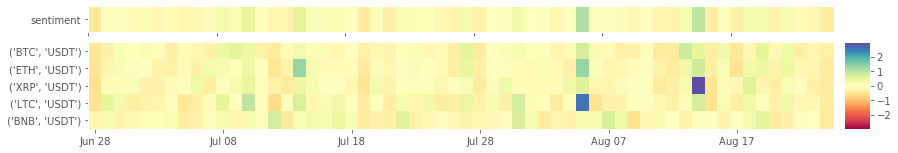

In [88]:
# Percentage change between the current and a prior volume.
df = utils.build_from_dict(data_dict, 'V')
df = df.pct_change().dropna()

# Make the colormap symmetric for both positive and negative values (min=-max)
vmin, vmax = plots.get_vmin_vmax(df, symmetric=True)
plots.evolution(df, norm=plots.midpoint_norm(0), vmin=vmin, vmax=vmax)

# Drawdown from peak

In [17]:
# Drawdown now
stats.dd.now(data_dict)

BTC  USDT    0.258992
BNB  USDT    0.277169
XRP  USDT    0.432232
ETH  USDT    0.458963
LTC  USDT    0.472570
dtype: float64

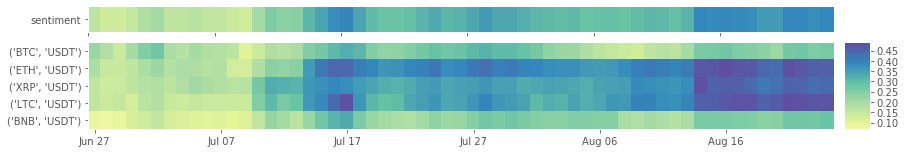

In [65]:
# Visualize the drawdown development across the pairs andtime scale
df = stats.dd.from_ohlc(data_dict)

plots.evolution(df, norm=plots.midpoint_norm(0))

# Correlation between pairs

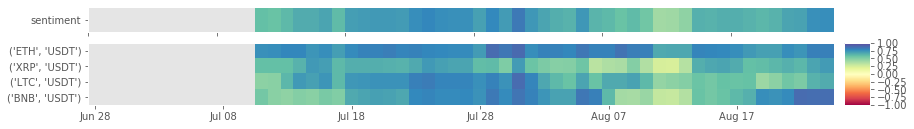

In [108]:
df = utils.build_from_dict(data_dict, 'M').pct_change().dropna()
df = stats.corr.rolling(df, ('BTC', 'USDT'), window=14)

plots.evolution(df, norm=plots.midpoint_norm(0), vmin=-1, vmax=1)

# Anomaly detection

## Price

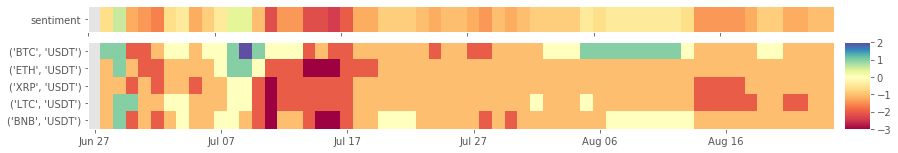

In [190]:
df = utils.build_from_dict(data_dict, 'M')
df = utils.expanding_normalize(df, 'std')
# Round to the nearest integer
df = utils.apply_thresholds(df)

plots.evolution(df, norm=plots.midpoint_norm(0))

## Volume

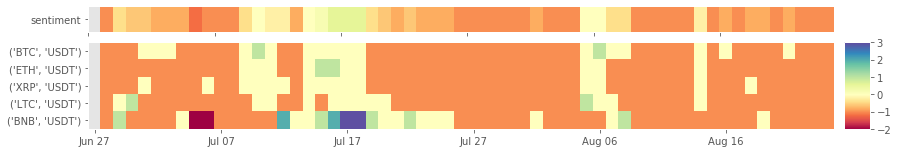

In [191]:
df = utils.build_from_dict(data_dict, 'V')
df = utils.expanding_normalize(df, 'std')
# Round to the nearest integer
df = utils.apply_thresholds(df)

plots.evolution(df, norm=plots.midpoint_norm(0))

# Technical indicators

## Relative Strength Index (RSI)

In [217]:
def rsi(df, window):
    delta = df.diff().dropna()
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # Calculate the EWMA
    roll_up = up.ewm(window, min_periods=window).mean()
    roll_down = down.abs().ewm(window, min_periods=window).mean()

    # Calculate the RSI based on EWMA
    return 100.0 - (100.0 / (1.0 + roll_up / roll_down))

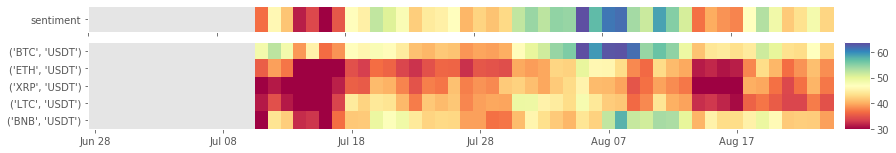

In [221]:
df = utils.build_from_dict(data_dict, 'C')
df = rsi(df, 14)
df = utils.trunk(df, [30, 70])

plots.evolution(df)

## Commodity Channel Index (CCI)

In [219]:
def cci(df, window):
    # (Typical Price  -  20-period SMA of TP) / (.015 x Mean Deviation)
    tp_sma = df.rolling(window).mean()
    md = df.rolling(window).apply(lambda a: np.fabs(a - a.mean()).mean())
    return (df - tp_sma) / (.015 * md)

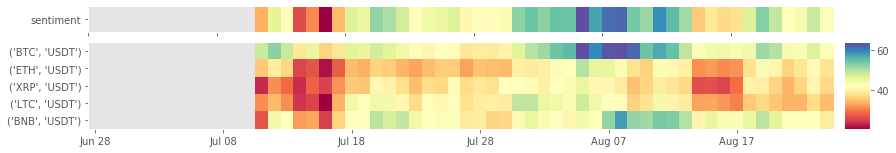

In [223]:
df = utils.build_from_dict(data_dict, 'C')
df = rsi(df, 14)
df = utils.trunk(df, [-100, 100])

plots.evolution(df)

## EMA crossover

In [233]:
def ema_crossover(df, ema_fast, ema_slow):
    # Generate EMA crossover signals
    fast = df.ewm(span=ema_fast, adjust=True).mean()
    slow = df.ewm(span=ema_slow, adjust=True).mean()
    df = fast - slow
    df[df > 0] = 1
    df[df < 0] = -1
    df = df.fillna(0)
    df = df.diff().dropna()
    pos_mask = df == 2
    neg_mask = df == -2
    df[pos_mask] = 1
    df[neg_mask] = -1
    df[~neg_mask & ~pos_mask] = 0
    return df

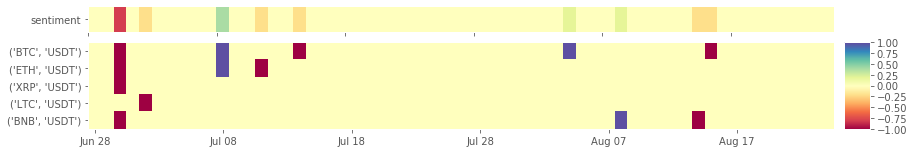

In [234]:
df = utils.build_from_dict(data_dict, 'C')
df = ema_crossover(df, 7, 21)

plots.evolution(df, norm=plots.midpoint_norm(0))

## Bollinger Bands

In [241]:
def bb(df, window, k):
    # Returns the lower and the upper bands
    sma = df.rolling(window=window, min_periods=window).mean()
    std = df.rolling(window=window, min_periods=window).std()
    BOLU = sma + std * k
    BOLD = sma - std * k
    return BOLD, BOLU

def bb_width(BOLD, BOLU):
    # Returns the width of the corridor between the bands
    return BOLU - BOLD

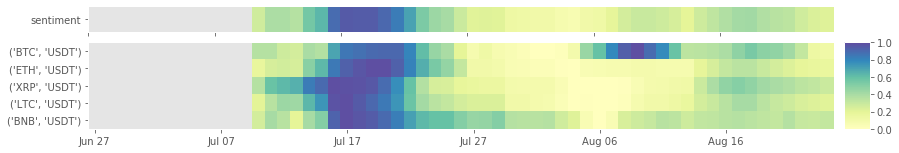

In [257]:
# How wide are bollinger bands?
df = utils.build_from_dict(data_dict, 'C')
df = bb_width(*bb(df, 14, 2))
df = utils.normalize(df, 'minmax')

plots.evolution(df, norm=plots.midpoint_norm(0))

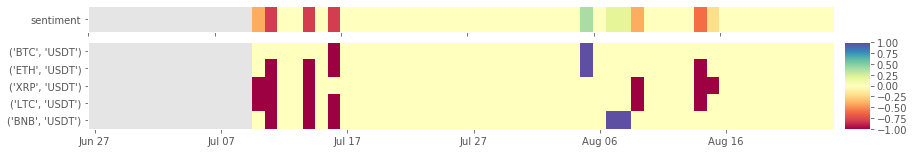

In [275]:
# Where is the price, inside or outside of BBs? A good indicator for sudden price jumps.
# > 1: exceeds the upper band
# < -1: exceeds the lower band
df = utils.build_from_dict(data_dict, 'C')
df = utils.rescale_dynamic_range(df, bb(df, 14, 2), [-1, 1])
df[df >= 1] = 1
df[df <= -1] = -1
df[(-1 < df) & (df < 1)] = 0

plots.evolution(df, norm=plots.midpoint_norm(0))